In [1]:
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging
import tensorflow as tf
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

import random
random.seed(seed)

from tensorflow.keras import backend as K
import tf2onnx
import onnxruntime as rt
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.version)

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/version/__init__.py'>


In [3]:
from sgde_client.auth import register

register()

Insert username: francesco
Insert email: francesco@example.com
Insert password: ········
Confirm password: ········


[2023-04-06 13:40:01,668][INFO] Registered as francesco (francesco@example.com)


User(username='francesco', email='francesco@example.com')

In [4]:
from sgde_client.auth import login

login()

Insert username: alberto
Insert password: ········


[2023-04-06 13:40:19,900][INFO] Successfully logged in


In [5]:
from sgde_client.auth import whoami

whoami()

[2023-04-06 13:40:22,654][INFO] Logged in as alberto (alberto@example.com)


User(username='alberto', email='alberto@example.com')

In [6]:
from sgde_client.auth import get_users

get_users()

,username,email
0,alberto,alberto@example.com
1,eugenio,eugenio@example.com
2,francesco,francesco@example.com


In [7]:
from sgde_client.auth import get_user

get_user("alberto")

User(username='alberto', email='alberto@example.com')

In [8]:
from sgde_client.exchange import get_generators

get_generators()

,name,description,dataset_name,dataset_description,format,image_size,conditioned,task,num_classes,model_size,...,generator_batch_size,classifier_epochs,classifier_batch_size,discriminator_rounds,generator_input_shape,classifier_gen_best_accuracy,classifier_real_best_accuracy,ssim,avg_ssim,owner
0,mnist_small_gan,# A Small GAN for MNIST\n ...with a slick M...,MNIST,A balanced grayscale image dataset containing ...,image,28,True,classification,10,small,...,64,100,64,3,74,0.807857,0.755571,0.997211,0.994779,alberto
1,fmnist_small_gan,# A Small GAN for FashionMNIST\n ...with a ...,FashionMNIST,A balanced grayscale image dataset containing ...,image,28,True,classification,10,small,...,64,100,64,3,74,0.807429,0.865571,0.983859,0.872248,alberto
2,cifar10_small_gan,# A Small GAN for CIFAR10\n ...with a slick...,CIFAR10,A balanced colored image dataset containing 10...,image,28,True,classification,10,small,...,64,100,64,3,74,0.463333,0.752667,0.902213,0.711955,alberto
3,cifar10_large_gan,# A Large GAN for CIFAR10\n ...with a slick...,CIFAR10,A balanced colored image dataset containing 10...,image,32,True,classification,10,large,...,64,100,64,3,138,0.173000,0.772333,0.300774,0.227956,eugenio
4,fmnist_large_gan,# A Large GAN for FashionMNIST\n ...with a ...,FashionMNIST,A balanced grayscale image dataset containing ...,image,32,True,classification,10,large,...,64,100,64,3,138,0.273857,0.873286,0.403051,0.190318,eugenio
5,mnist_large_gan,# A Large GAN for MNIST\n ...with a slick M...,MNIST,A balanced grayscale image dataset containing ...,image,32,True,classification,10,large,...,64,100,64,3,138,0.234429,0.962000,0.356022,0.197496,eugenio
6,my_1epoch_gan,\n # An underperforming GAN for MNIST\n ...,MNIST,A balanced grayscale image dataset containing ...,image,28,True,classification,10,small,...,64,1,64,3,74,0.084429,0.715857,0.199260,0.167074,alberto


In [10]:
from sgde_client.exchange import get_generator, download_generator

metadata = get_generator("mnist_small_gan")
gen_path = download_generator("mnist_small_gan")

[2023-04-06 13:43:51,799][INFO] Generator downloaded at /src/mnist_small_gan_230406134351.onnx


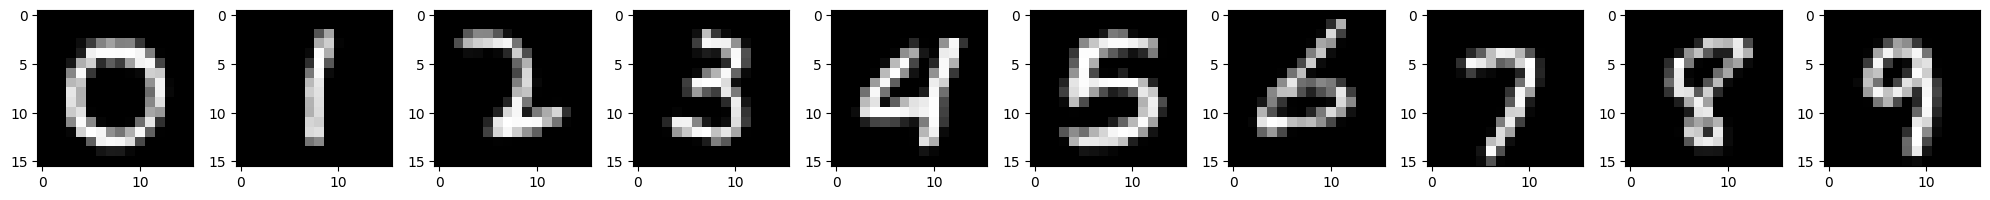

In [13]:
from sgde_client.models.inference import generate_samples_onnx

_ = generate_samples_onnx(
    num_samples=10,
    path=gen_path, 
    input_shape=metadata.generator_input_shape, 
    num_classes=metadata.num_classes, 
    verbose=True,
)

11490434/11490434 [==============================] - 0s 0us/step
Metadata extraction started...
Metadata extraction completed!
Data processing started...
	 Dataset reshaping started...
	 Dataset reshaping completed!
	 Dataset resizing started...
	 Dataset resizing completed!
	 Dataset normalization started...
	 Dataset normalization completed!
Data processing completed!
Classifier training on real data started...
985/985 - 50s - loss: 0.6971 - accuracy: 0.7606 - val_loss: 0.5591 - val_accuracy: 0.8417 - lr: 0.1000 - 50s/epoch - 51ms/step
Classifier training on real data completed!
Generator building started...
Generator building completed!
Generator training started...


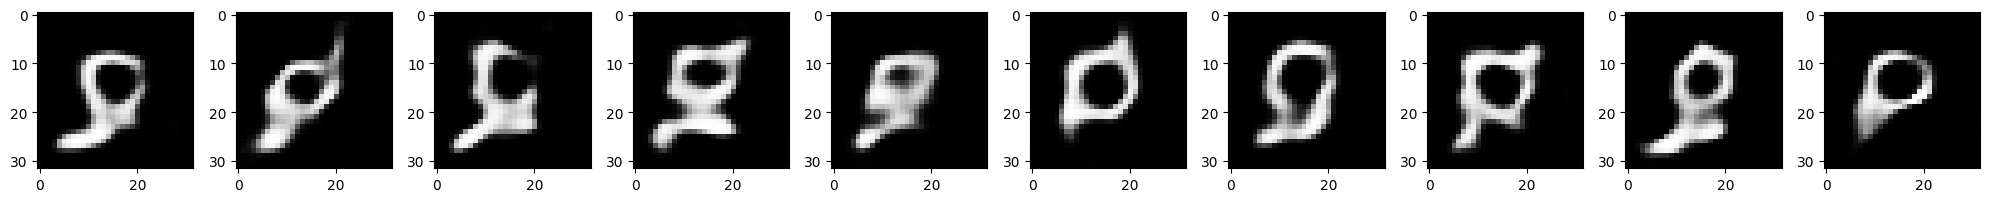

985/985 - 38s - loss: 1.8358 - d_loss: 1.4095 - g_loss: 0.4262 - 38s/epoch - 38ms/step
Generator training completed!
Generator saving started...
Generator saving completed!
Sampling started...
Sampling completed!
Similarity metrics computation started...
Similarity metrics computation completed!
Classifier training on generated data started...
985/985 - 12s - loss: 1.7991 - accuracy: 0.3449 - val_loss: 4.9434 - val_accuracy: 0.1201 - lr: 0.1000 - 12s/epoch - 12ms/step
Classifier training on generated data completed!


In [15]:
from sgde_client.models.training import train_image_generator

(X_train, y_train), (X_test, y_test) = tfk.datasets.mnist.load_data()
X = np.concatenate([X_train, X_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

gen_path, private_metadata = train_image_generator(
    name="mnist_small_gan_2",
    description="""
    # A Small GAN for MNIST
    ...with a slick Markdown description.
    """,
    X=X,
    y=y,
    epochs=1,
    classifier_epochs=1,
    batch_size=64,
    image_size=32,
    model_size="small",
    task="classification",
    sub_task="Handwritten digit classification",
    data_description="A balanced grayscale image dataset containing 10 different classes",
    dataset_name="MNIST",
    verbose=True,
)

In [16]:
from sgde_client.exchange import upload_generator

upload_generator(gen_path, private_metadata)

[2023-04-06 13:49:58,843][INFO] Generator uploaded as mnist_small_gan_2


Generator(name='mnist_small_gan_2', description='\n    # A Small GAN for MNIST\n    ...with a slick Markdown description.\n    ', dataset_name='MNIST', dataset_description='A balanced grayscale image dataset containing 10 different classes', format='image', image_size=32, conditioned=True, task='classification', num_classes=10, model_size='small', generator_epochs=1, generator_batch_size=64, classifier_epochs=1, classifier_batch_size=64, discriminator_rounds=3, generator_input_shape=74, classifier_gen_best_accuracy=0.1201428547501564, classifier_real_best_accuracy=0.8417142629623413, ssim=0.2852911651134491, avg_ssim=0.25286364555358887, owner='alberto')